# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Homework 3 Solutions
</font>

##### **<font color="red">Content aware image resizing (65 points)</font>**
As part of this assignment, you will be developing Python routines to implement a simplified version of the content-aware image resizing technique described in Shai Avidan and Ariel Shamir’s SIGGRAPH 2007 paper, “Seam Carving for Content Aware Image Resizing”.   
<br>
The paper is available here: http://www.faculty.idc.ac.il/arik/SCWeb/imret/index.html. Please read the paper, with emphasis on sections 3, 4.1, and 4.3.
<br>
For this assignment, we will restrict attention to shrinking images or making images smaller. The goal is to implement the algorithm and analyze its performance on multiple images.
<br>
Please consult the instructions supplied with the homework for 

##### <font color="yellow">Preamble</font>

In [61]:
# Preamble
import cv2 as cv
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output    # new
import numpy as np

#### <font color="yellow">Helper functions</font>
* `im2double()` converts a `uint` grayscale image into `double` format
* `shrinkWidth()` shrinks the width of an image by `numPixels`. This is accomplished by repeated calls to the function `findVerticalSeam` which finds a single pixel wide vertical seam characterized by the smallest cumulative gradient energy.
<br>
Your task is to implement the function `findVerticalSeam`.

In [62]:
# Helper functions
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(float) / info.max # Divide all values by the largest possible value in the datatype

# Helper function to shrink width of image by specified number of pixels
def shrinkWidth(inp_im,numPixels):
    fig = plt.figure()
    #
    im_old = inp_im
    [nR,nC] = im.shape
    for niter in range(numPixels):  # niter spans the range 0 to numPixels-1
        #
        [optVertSeamPath,E,M] = findVerticalSeam(im_old)
        #                    
        # Initialize storage for new image with one less column
        im_new = im_old[:,0:-1]
        #
        # Example illustrating the process of dropping a specific column from an array
        # Can use np.delete, but it tends to be slow
        # arr1D = (1,2,3,4,5)
        # nC = arr1D.shape
        # dropCol = 2
        # print(arr1D[0:dropCol])
        # print(arr1D[-(nC-1-dropCol):])
        # print(np.hstack( (arr1D[0:dropCol], arr1D[-(nC-1-dropCol):] ) ))
        
        # Discard specific column from each row of im_old
        for r in np.arange(0,nR,1):   # r spans the range 0 to nR-1
            nC = im_old.shape[1]
            dropCol = optVertSeamPath[r]     
            im_new[r,:] = np.hstack( ( im_old[r,0:dropCol], im_old[r,-(nC-1-dropCol):]) )  
        #
        # Display
        # https://thepythonguru.com/python-string-formatting/
        plt.title('Iteration={:2d}'.format(niter+1) + ' , Image Size = ' + np.array2string(np.array(im_new.shape)) )
        plt.imshow(im_new, cmap='gray')
        plt.plot( optVertSeamPath, range(nR), color='red', linewidth=2)
        plt.pause(0.01)
        clear_output(wait=True)
        # 
        # Re-assign new image as old image & continue loop
        im_old = im_new
    #
    outp_im = im_new
    return outp_im
    

#### <font color="yellow">Your implementation of `findVerticalSeam(im)` goes here</font>  <font color="red">(20 points)</font>
The function accepts an input image `im_old`. The function outputs the column of the vertical seam associated with each row of the image `im_old`. The column is zero-indexed consistent with Python’s convention. 

In [63]:
def findVerticalSeam(im_old):
    sz = im_old.shape
    
    # Sobel filter for computing image derivative in X & Y direction
    Gx = cv.Sobel(im_old, cv.CV_64F, dx=1, dy=0)    # output data-type is CV_64F
    Gy = cv.Sobel(im_old, cv.CV_64F, dx=0, dy=1)    # output data-type is CV_64F

    EnergyFn = abs(Gx) + abs(Gy)

    [nR,nC] = EnergyFn.shape
  
    # Pad columns to left & right with Infinity
    mtxM = cv.copyMakeBorder( EnergyFn, 0, 0, 1, 1, cv.BORDER_CONSTANT, None, np.Inf )   # to avoid handling border elements
    Energy_each_VertSeam = mtxM[-1,:]
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Forward recursion....First row to last row
    # Populate matrix M using the Energy function E 
    # Process optimized for vertical seam 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # r:(1,nR-1) start from second row in original image (2nd row in padded image)
    for r in np.arange(1,nR,1):    
    # c:(1,nC) scan along columns 2 to nC+1, which maps to index (1,nC+1) in numpy  
      for c in np.arange(1,nC+1,1):     
        # identify 3 nearest neighbors immediately above pixel (r,c)
        threeNN_above_pixel = mtxM[r-1, [c-1,c,c+1]]
        # print(np.amin(threeNN_above_pixel))
        # see which one contributes to least accumulated gradient magnitude and add to E[r,c]
        mtxM[r, c] += np.amin(threeNN_above_pixel)
        
    # f = plt.figure()
    # plt.imshow(EnergyFn, cmap='gray')            

    # f = plt.figure()
    # plt.imshow(mtxM, cmap='gray')            
  
    # Energy of each candidate vertical seam is given by last row of 
    Energy_each_VertSeam = mtxM[-1,:]
    
    # find vertical seam with least accumulated energy
    mnCol = np.argmin(Energy_each_VertSeam)
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Backtracking....Last row to first row
    # Process optimized for vertical seam
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    c = mnCol                                           # Initialize with column in last row of mtxM with smallest value  
    optVertSeamPath = np.zeros(sz[0],np.uint16)
    for r in np.arange(nR-1 , 0 ,-1):   # r:(nR-1,1) does not include 0
      optVertSeamPath[r] = c            # pixel (r,c) is along the vertical seam    
      # examine 3 nearest neighbors above pixel (r,c) 
      threeNN_above_pixel = mtxM[r-1, [c-1,c,c+1]]    
      # see which one contributes to least accumulated gradient magnitude
      mnLoc = np.argmin(threeNN_above_pixel) # mnLoc is either 0, 1, 2
      # update column index of vertical seam...index 0, 1, 2 should map to c-1, c, c+1 respectively
      c += (mnLoc - 1)  # c = c + (mnLoc - 1)
    #  
    optVertSeamPath[0] = c
    
    # Subtract 1 from <<optVertSeamPath>> as we padded the matrix M with columns to the left & right
    # This will yield the numpy column index of the vertical seam in the image <<im>>
    optVertSeamPath = optVertSeamPath - 1
    
    return optVertSeamPath, EnergyFn , mtxM


#### <font color="yellow">Read the grayscale images using imread and convert to double using `im2double`</font>

In [64]:
fileName = ('lake.jpg','Dallas-Skyline.jpg')
imgNum = 0  # default is lake.jpg
dirPath = '.\\Data_SeamCarving\\'

# Read in Grayscale mode
im = cv.imread( dirPath + fileName[imgNum] , cv.IMREAD_GRAYSCALE )

# Convert to double using im2double()
im = im2double(im)


#### <font color="yellow">Deliverables </font>
##### <font color="red">Question-1        (15 points)</font>
Run this section of code on the <font color="cyan">lake.jpg</font> image & answer the following questions <font color="red">(2 points each)</font>.
1. What is the difference between the two calls to `findVerticalSeam()`. HINT: Look at the output variables.
2. What are the two calls to `np.transpose()` trying to accomplish?
3. Why is it that the energy function `E` remains unchanged in the two calls to `findVerticalSeam()`. HINT: How is `E` obtained?
4. What do you think is happening in lines 24, 30? Why are the variables reversed between the two calls?
5. Comment on why you think the seams look the way they do given the original image’s content.					

<b>Paste the screenshots into the word document supplied with the assignment. <font color="red">(5 points)</font></b>

Text(0.5, 1.0, 'Horizontal Seam')

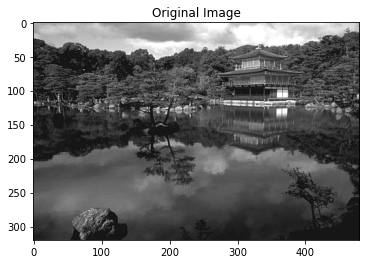

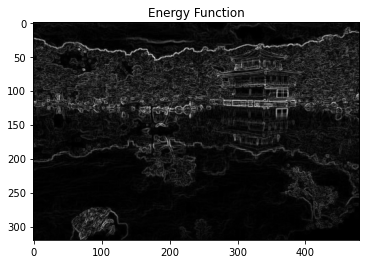

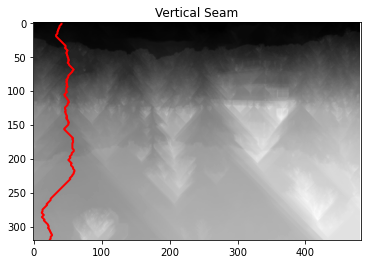

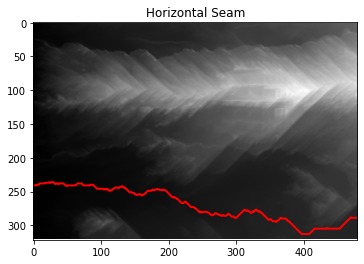

In [65]:
[nR,nC] = im.shape

# Vertical Seam
[optVertSeamPath,E,Mv] = findVerticalSeam(im)

# Horizontal Seam
[optHorizSeamPath,E,Mh] = findVerticalSeam(np.transpose(im))
Mh = np.transpose(Mh)
E = np.transpose(E)

# Display original image
fig = plt.figure()
plt.imshow(im,cmap='gray')
plt.title('Original Image')
#
# Display E
fig = plt.figure()
plt.imshow(E,cmap='gray')
plt.title('Energy Function')
#
# Display M for vertical seam
fig = plt.figure()
plt.imshow(Mv,cmap='gray')
plt.plot( optVertSeamPath, range(nR), color='red', linewidth=2)
plt.title('Vertical Seam')
#
# Display M for horizontal seam
fig = plt.figure()
plt.imshow(Mh,cmap='gray')
plt.plot( range(nC), optHorizSeamPath, color='red', linewidth=2)
plt.title('Horizontal Seam')

##### <font color="red">Question-2        (10 points)</font>
Invoke `shrinkWidth` function on the provided image <font color=cyan>lake.jpg</font> with `numPixels = 100` (in other words, shrink the width by 100 pixels). 
<br>
Display the original image and the resized image in individual figures.

<b>Paste the screenshots into the word document supplied with the assignment.</b>

Text(0.5, 1.0, 'Smart Resize Image, Image Size = [320 465]')

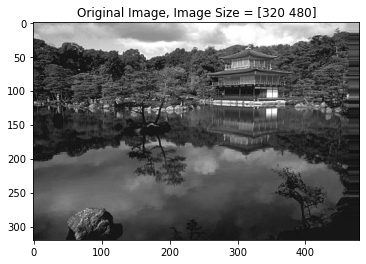

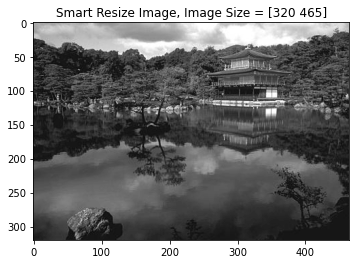

In [66]:
# Number of columns to drop
numCols_to_drop = 15

# Call shrink_width
im_shrink = shrinkWidth(im,numCols_to_drop)

# Display original image
plt.figure()
plt.clf()
plt.imshow(im,cmap='gray')
plt.title('Original Image, Image Size = ' + np.array2string(np.array(im.shape)) )

# Display original image
plt.figure()
plt.clf()
plt.imshow(im_shrink,cmap='gray')
plt.title('Smart Resize Image, Image Size = ' + np.array2string(np.array(im_shrink.shape)) )

##### <font color="red">Question-3       (10 points, 2.5 points each)</font>
Attempt seam carving on the <font color="cyan">Dallas-Skyline.jpg</font> 
Please furnish the following in the writeup: 
* Energy function `E`
* matrix `M` for vertical seam
* result of `shrinkWidth` for `numPixels>100`. 
* Does the result seem reasonable to you. If not comment on what you think appears to be happening.
  
<b>Paste the screenshots into the word document supplied with the assignment.</b>

##### <font color="red">Question-4       (ECE-7382 only, 10 points)</font>
Attempt seam carving on an image of your choosing. 
Please furnish the following in the writeup: 
* Energy function `E`
* matrix `M` for horizontal and vertical seams
* result of `shrinkWidth` for `numPixels=50`  